# TESTING KNN, AND ANN MODELS FOR THE RSA CLUSTER LABEL PREDICTION

In this notebook, we select the best ANN model out of 500 models (50 randomly initiliased models from 10 different seeds) and test this model, as well as the KNN on the blind set.

### IMPORTING NECESSARY PACKAGES

In [1]:
from fragsys_ml import *
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

2023-07-18 10:44:13.146926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 10:44:14.486904: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### READING INPUT DATA

In [2]:
main_dir = "./../"
results_dir = os.path.join(main_dir, "results")
figs_dir = os.path.join(main_dir, "figs")

In [3]:
rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))
cluster_membership = load_pickle(os.path.join(results_dir, "rsa_cluster_membership.pkl"))
rsa_profs = load_pickle(os.path.join(results_dir, "rsa_profs.pkl"))
ud_mat = pd.read_pickle(os.path.join(results_dir, "UD_df.pkl"))
vector_df = pd.read_pickle(os.path.join(results_dir, "rsa_vectors.pkl"))

In [4]:
vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
H0Y4R8_0_BS0,0.150,0.000,0.000,0.167,0.167,0.333,0.000,0.167,0.167,0.0,0.0
O43809_0_BS0,0.600,0.375,0.250,0.083,0.167,0.042,0.042,0.000,0.042,0.0,0.0
O43809_0_BS1,0.325,0.231,0.077,0.231,0.077,0.077,0.077,0.077,0.154,0.0,0.0


In [5]:
vector_df.shape

(293, 11)

### CREATING LABEL DATAFRAME

In [6]:
label_df = pd.DataFrame.from_dict(rsa_cluster_dict, orient = "index", columns = ["label"])

In [7]:
label_df = label_df - 1

In [8]:
round(label_df.label.value_counts().sort_index()/len(label_df),2)

0    0.16
1    0.43
2    0.31
3    0.10
Name: label, dtype: float64

In [9]:
label_df.shape

(293, 1)

In [10]:
X = vector_df.sort_index() # here, X is still a dataframe. Thus, we maintain binding site IDs
y = label_df.sort_index()    # here, y is still a list

### DATA SPLIT IN MODEL (10/11) (USED FOR TRAINING) AND BLIND (USED FOR FINAL TESTING) (1/11) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [11]:
X_model, X_blind, y_model, y_blind = train_test_split(X, y, test_size = 0.091, random_state = 12345, shuffle = True, stratify = y) ### X_blind and y_blind will be the blind test at the end

In [12]:
list(X.index) == list(y.index)

True

In [12]:
dump_pickle(y_blind.index.tolist(), os.path.join(results_dir, "x_blind.pkl"))

In [13]:
X_model_df, X_blind_df, y_model_df, y_blind_df = train_test_split(X, y, test_size = 0.091, random_state = 12345, shuffle = True, stratify = y) ### X_blind and y_blind will be the blind test at the end

In [14]:
print(X_model_df.shape)
print(X_blind_df.shape)
print(y_model_df.shape)
print(y_blind_df.shape)

(266, 11)
(27, 11)
(266, 1)
(27, 1)


In [15]:
round(y_model.label.value_counts().sort_index()/len(y_model),2)

0    0.16
1    0.43
2    0.31
3    0.10
Name: label, dtype: float64

In [16]:
round(y_blind.label.value_counts().sort_index()/len(y_blind),2)

0    0.15
1    0.44
2    0.30
3    0.11
Name: label, dtype: float64

## ANALYSIS OF DIFFERENT SEEDS AND BEST MODEL SELECTION

In [17]:
wd = os.path.join(main_dir, "ANN_results/diff_seeds")

In [18]:
seeds = os.listdir(wd)

In [19]:
print(seeds)

['99914', '12303', '27520', '63945', '277', '49757', '51094', '3716', '56724', '79619']


In [20]:
best_acc_rows = []
weird_runs = []
for seed in seeds:

    seed_dir = os.path.join(wd, str(seed))
    hist_dir = os.path.join(seed_dir, "hists")
    hist_files = os.listdir(hist_dir)
    for hist in hist_files:
        
        hist_df = pd.read_csv(os.path.join(hist_dir, hist))
        data = hist.split("_")
        n = int(data[1])
        f_epoch = int(data[4])
        hist_df["seed"] = seed
        hist_df["n"] = n
        if f_epoch == -100:
            weird_runs.append(os.path.join(hist_dir, hist))
            f_epoch = 299

        acc = hist_df.loc[f_epoch,"val_accuracy"]
        best_acc_rows.append(hist_df.loc[f_epoch, :])

In [21]:
best_models = pd.DataFrame(best_acc_rows)
best_models["epoch"] = best_models.index
best_models.seed = best_models.seed.astype(int)
best_models.n = best_models.n.astype(int)
best_models.epoch = best_models.epoch.astype(int)
best_models = best_models.sort_values(["seed", "n"])
best_models.index = list(range(len(best_models)))

### COMPARISON BETWEEN DIFFERENT SEED MODELS

In [22]:
best_models.epoch.median() # median of epoch in which validation accuracy is best, weights of the model come from this epoch

43.0

In [23]:
len(best_models.query('epoch < 20'))/len(best_models)*100 # no models stop training before epoch 20

0.0

### Distribution of final training epoch

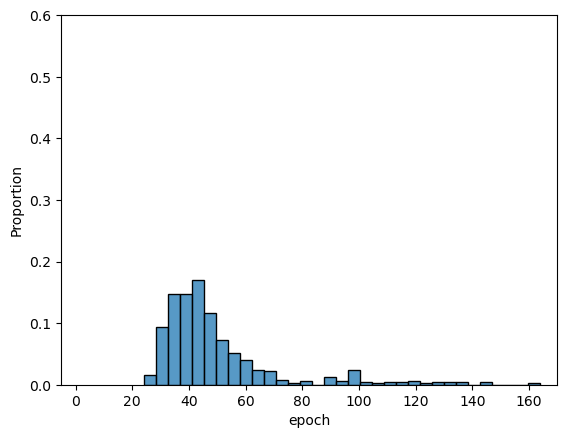

In [24]:
sns.histplot(best_models.epoch, stat = "proportion")
plt.xlim(-5, 170)
plt.ylim(0,0.6)
plt.show()

In [22]:
best_models.head(3)

,loss,accuracy,val_loss,val_accuracy,seed,n,epoch
0,0.207761,0.952830,0.283437,0.962963,277,0,53
1,0.198641,0.943396,0.279275,0.962963,277,1,55
2,0.215212,0.948113,0.279875,0.962963,277,2,53


In [36]:
best_models.to_pickle(os.path.join(results_dir, "ML_seed_models_df.pkl"))

#### VALIDATION LOSS

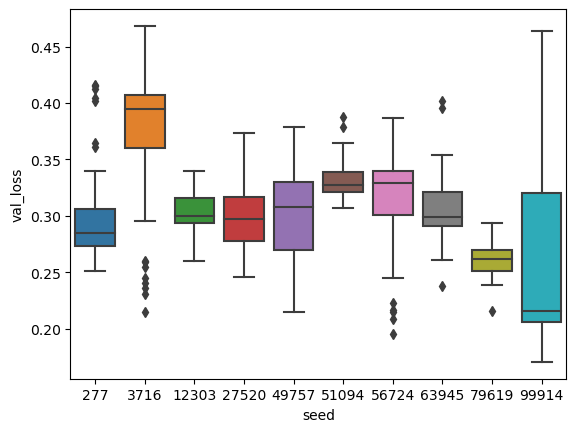

In [25]:
sns.boxplot(x = "seed", y = "val_loss", data = best_models)
plt.show()

#### VALIDATION ACCURACY

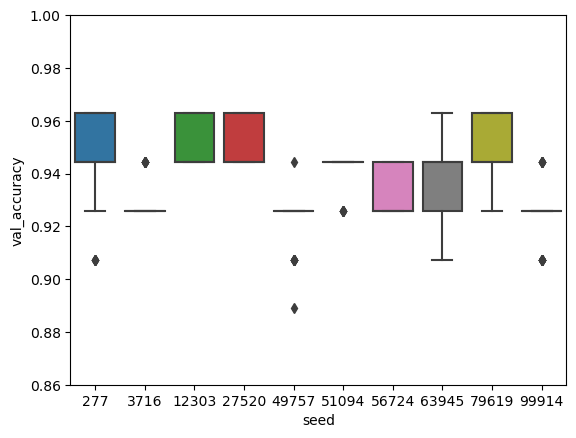

In [26]:
sns.boxplot(x = "seed", y = "val_accuracy", data = best_models)
plt.ylim(0.86,1)
plt.show()

#### ALL TRAINING METRICS ACROSS SEEDS (N = 500)

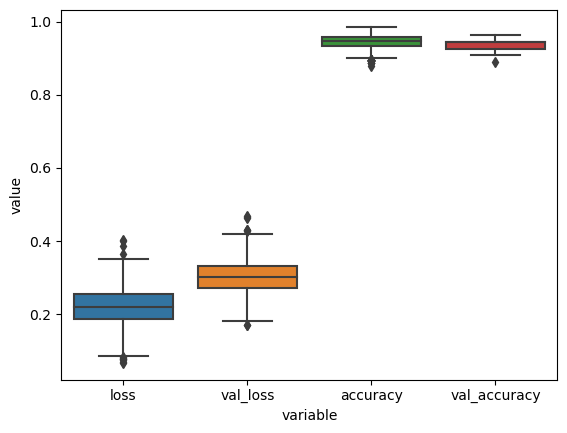

In [27]:
sns.boxplot(x = "variable", y = "value", data = pd.melt(best_models.loc[:,['loss', 'val_loss', 'accuracy', 'val_accuracy']]))
plt.show()

#### SELECTING BEST MODEL

In [28]:
best_models.query('seed == 79619 & n == 2')

,loss,accuracy,val_loss,val_accuracy,seed,n,epoch
402,0.15766,0.957547,0.244619,0.962963,79619,2,49


In [29]:
best_models.query('val_accuracy > 0.95 & val_loss < 0.25').sort_values(by=["val_accuracy", "val_loss", "accuracy", "loss"])

,loss,accuracy,val_loss,val_accuracy,seed,n,epoch
402,0.157660,0.957547,0.244619,0.962963,79619,2,49
443,0.180022,0.962264,0.246044,0.962963,79619,43,46
427,0.165029,0.966981,0.249912,0.962963,79619,27,48


The best model chosen is the following: seed = 79619, n = 2, epoch = 49, val_accuracy = 0.96. This decision was made based on the models' validation accuracy, validation loss, and training accuracy, and loss in that order.

In [30]:
ff = pd.read_csv("./../ANN_results/diff_seeds/79619/hists/79619_2_hist_epoch_49_train_acc_0.96.csv")

### BEST MODEL TRAINING VISUALISATION

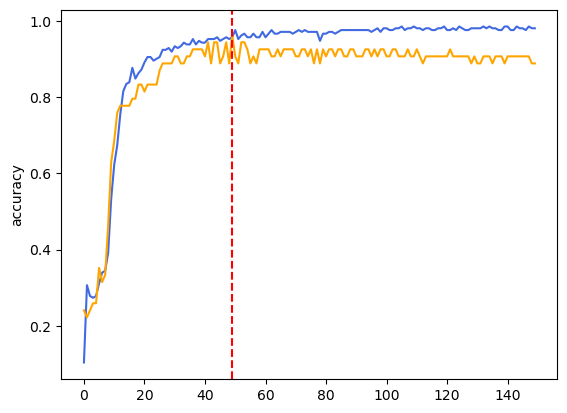

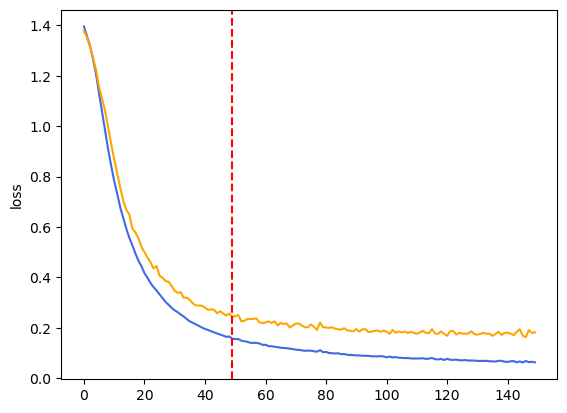

In [31]:
plot_acc(ff, 49)
plt.show()
plot_loss(ff, 49)
plt.show()

## PREDICTING ON BLIND TEST SET WITH ANN

The final ANN model presents an accuracy of 96.3%, with 

0.963


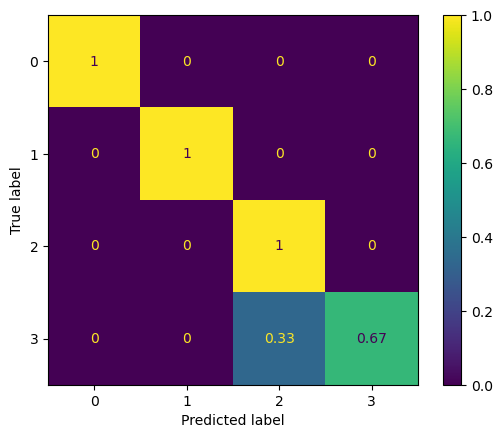

In [22]:
model_path = "./../ANN_results/diff_seeds/79619/models/79619_2_model_epoch_49_train_acc_0.96.h5"
final_model = keras.models.load_model(model_path)
final_preds = final_model.predict(x = X_blind, batch_size = 27, verbose = 0)
rounded_predictions = np.argmax(final_preds, axis = -1)
cm = confusion_matrix(y_true = y_blind, y_pred = rounded_predictions, normalize = 'true')
cm_display = ConfusionMatrixDisplay(cm).plot()
blind_acc = sum(rounded_predictions == np.array(y_blind.label))/len(rounded_predictions)
print(round(blind_acc, 3))

#### Confidence interval of ANN accuracry (proportion)

In [33]:
lw, up = proportion_confint(count = 26,    # Number of "successes"
                   nobs = 27,    # Number of trials
                   alpha = (1 - 0.95),
                  method = "wilson")
print(round(blind_acc, 2))
print(round(lw, 2), round(up,2))

0.96
0.82 0.99


In [34]:
ANN_pred_df = pd.DataFrame(np.around(final_preds,2))
ANN_pred_df["pred"] = rounded_predictions
ANN_pred_df["real"] = y_blind.label.tolist()
ANN_pred_df.index = y_blind_df.index

In [35]:
ANN_pred_df[ANN_pred_df.pred != ANN_pred_df.real]

,0,1,2,3,pred,real
Q32ZE1_0_BS3,0.0,0.0,0.67,0.32,2,3


In [36]:
ANN_pred_df[ANN_pred_df.pred != ANN_pred_df.real].index.tolist()

['Q32ZE1_0_BS3']

In [52]:
dump_pickle(ANN_pred_df[ANN_pred_df.pred != ANN_pred_df.real].index.tolist(), os.path.join(results_dir, "x_wrong_ANN.pkl"))

### Confidence in ANN blind set predictions (N = 27)

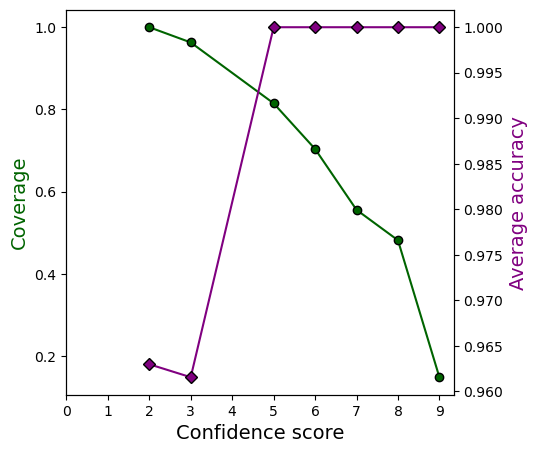

In [48]:
conf_good_df1, conf_good_df2 = get_confidences_df_blind(final_preds, rounded_predictions, y_blind.label)

plot_conf_acc_cov(conf_good_df2)

## PREDICTING ON BLIND TEST SET WITH KNN

#### Trying different number of K nearest neighbours

In [38]:
knn_acc_dict = {}
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(ud_mat.loc[X_model.index, X_model.index], y_model)
    #Predict the response for test dataset
    y_pred_KNN = knn.predict(ud_mat.loc[X_blind.index, X_model.index])
    acc_pred = metrics.accuracy_score(y_blind, y_pred_KNN)
    blind_acc_KNN = sum(y_pred_KNN == y_blind.label)/len(y_pred_KNN)
    knn_acc_dict[i] = round(blind_acc_KNN, 3)

/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sk

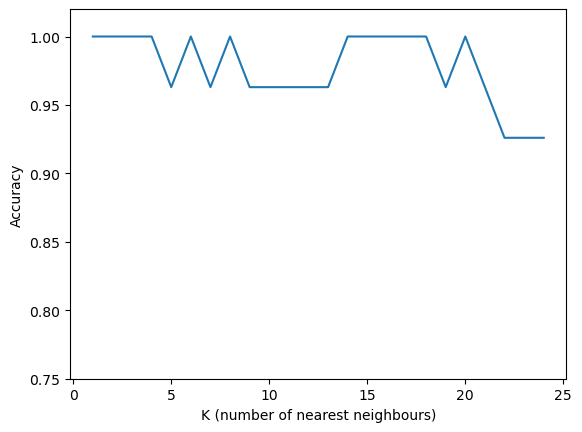

In [42]:
plt.plot(knn_acc_dict.keys(), knn_acc_dict.values())
plt.ylim(0.75, 1.02)
plt.xlabel("K (number of nearest neighbours)")
plt.ylabel("Accuracy")
plt.show()

In [24]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [25]:
ud_mat.loc[X_model.index,X_model.index].shape # used for training: square distance matrix of 266 training binding sites

(266, 266)

In [26]:
ud_mat.loc[X_blind.index, X_model.index].shape # used for testing: distance between the 27 test sites to the 266 sites used for training

(27, 266)

In [27]:
knn.fit(ud_mat.loc[X_model.index, X_model.index], y_model)

#Predict the response for test dataset
y_pred_KNN = knn.predict(ud_mat.loc[X_blind.index, X_model.index])

acc_pred = metrics.accuracy_score(y_blind, y_pred_KNN)

/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


1.0


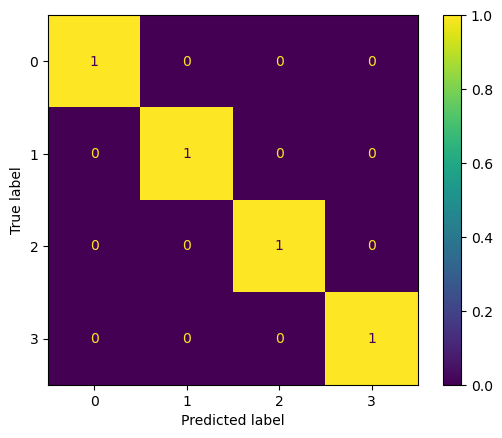

In [28]:
cm_KNN = confusion_matrix(y_true = y_blind, y_pred = y_pred_KNN, normalize = 'true')
cm_display_KNN = ConfusionMatrixDisplay(cm_KNN).plot()
blind_acc_KNN = sum(y_pred_KNN == y_blind.label)/len(y_pred_KNN)
print(round(blind_acc_KNN, 3))

#### Confidence interval of KNN accuracry (proportion)

In [43]:
lw, up = proportion_confint(count = 27,    # Number of "successes"
                   nobs = 27,    # Number of trials
                   alpha = (1 - 0.95),
                  method = "wilson")
print(round(blind_acc_KNN, 2))
print(round(lw, 2), round(up,2))

1.0
0.88 1.0


In [44]:
KNN_pred_df = pd.DataFrame(list(zip(y_pred_KNN, y_blind.label.tolist())), columns = ["pred", "real"])
KNN_pred_df.index = y_blind_df.index

In [45]:
KNN_pred_df[KNN_pred_df.pred != KNN_pred_df.real]

,pred,real


In [46]:
KNN_pred_df[KNN_pred_df.pred != KNN_pred_df.real].index.tolist()

[]

In [47]:
dump_pickle(KNN_pred_df[KNN_pred_df.pred != KNN_pred_df.real].index.tolist(), os.path.join(results_dir, "x_wrong_KNN.pkl"))

## CONCLUSIONS

The accuracy of the ANN, and KNN models trained from fragsys are 26/27 = 0.96, 95% CI = [0.82, 0.99] for ANN, and 27/27 = 1.0, 95% CI = [0.88, 1.0] for KNN. The 95% CI for the two accuracies, overlap, so we can conclude there is no significant difference between the performance of the two models.